0.25


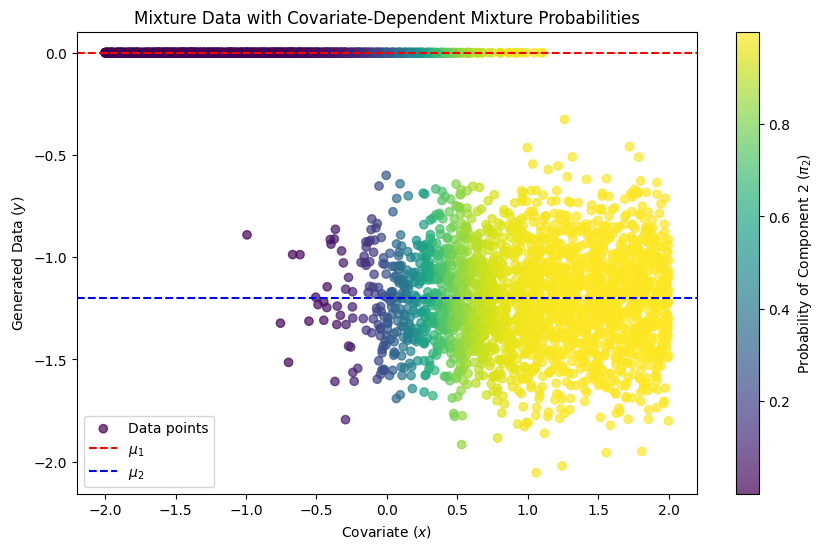

In [93]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed( 12)
n_samples = 5000
a, b = 5.0, -1.0  # Coefficients for logistic regression to control mixture probabilities
mu_1, sigma_1_sq = 0.0, 0.2
mu_2, sigma_2_sq = -1.20,  0.5


print(sigma_2_sq   **2 )

sd_noise= 1
# Covariates
x = np.random.uniform(-2, 2, n_samples)

# Mixture probabilities
pi_2 = 1 / (1 + np.exp(-(a * x + b)))  # Sigmoid function for covariate-dependent pi_2
pi_1 = 1 - pi_2  # Ensure pi_1 + pi_2 = 1

# Generate data
y = np.zeros(n_samples)
betahat = np.zeros(n_samples)
c = np.zeros(n_samples, dtype=int)  # Ensure c is an integer array
for i in range(n_samples):
    # Use .item() to extract the scalar from np.random.choice
    c[i] = np.random.choice([0, 1], p=[pi_1[i], pi_2[i]])
    if c[i] == 0:
        y[i] = 0
        betahat[i]= y[i]+ np.random.normal(0,  sd_noise**2)
    else:
        y[i] = np.random.normal(mu_2,  sigma_2_sq   **2 )
        betahat[i]= y[i]+ np.random.normal(0,  sd_noise**2)


# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=pi_2, cmap='viridis', label='Data points', alpha=0.7)
plt.colorbar(label='Probability of Component 2 ($\pi_2$)')
plt.axhline(mu_1, color='red', linestyle='--', label='$\mu_1$')
plt.axhline(mu_2, color='blue', linestyle='--', label='$\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel('Generated Data ($y$)')
plt.title('Mixture Data with Covariate-Dependent Mixture Probabilities')
plt.legend()
plt.show()


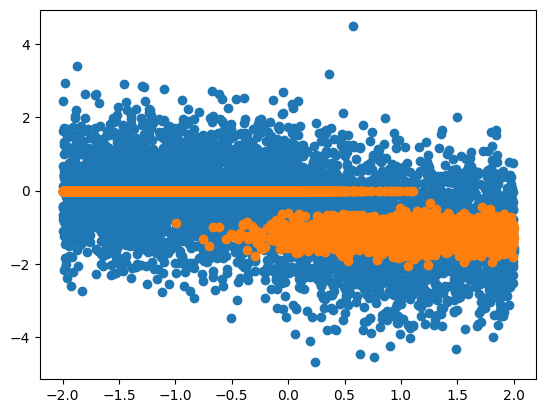

In [94]:

plt.scatter(x,betahat)

plt.scatter(x,y)


In [95]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the MDN model

class MDN(nn.Module):
    def __init__(self, input_dim):
        super(MDN, self).__init__()
        # Define the neural network layers
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # Output: logit for pi_2
        )
        
        # Fixed parameters for component 1
        self.mu_1 = 0.0  # Fixed mean for component 1
        self.sigma_1_sq = 0.1  # Fixed variance for component 1
        
        # Learnable global parameters for component 2
        self.mu_2 = nn.Parameter(torch.tensor(0.0))  # Initialize mu_2
        self.log_sigma2_sq = nn.Parameter(torch.tensor(0.0))  # Initialize log(sigma_2^2)

    def forward(self, x ):
        logit_pi2 = self.fc(x).squeeze()  # Squeeze to remove extra dimensions
        
        # Compute parameters
        pi_2 = torch.sigmoid(logit_pi2)  # Ensure pi_2 in (0, 1)
        pi_1 = 1 - pi_2  # Ensure pi_1 + pi_2 = 1
        sigma_2_sq = torch.exp(self.log_sigma2_sq)  # Ensure sigma_2^2 > 0
        
        return pi_1, pi_2, self.mu_2, sigma_2_sq

# Loss function: Negative Log Likelihood of the mixture distribution
def mdn_loss(pi_1, pi_2, mu_2, sigma_2_sq, targets,sd_noise):
    # Fixed parameters for component 1
    mu_1 = torch.tensor(0.0)  # Convert to tensor
    sigma_1_sq_total = torch.tensor(sd_noise**2, dtype=torch.float32)   # Convert to tensor
    sigma_2_sq_total =  sigma_2_sq+ sd_noise**2
    # Gaussian PDFs
    p1 = (1 / torch.sqrt(2 * torch.pi * sigma_1_sq_total)) * torch.exp(-0.5 * ((targets - mu_1) ** 2) / sigma_1_sq_total)
    p2 = (1 / torch.sqrt(2 * torch.pi * sigma_2_sq_total)) * torch.exp(-0.5 * ((targets - mu_2) ** 2) / sigma_2_sq_total)

    # Mixture PDF
    mixture_pdf = pi_1 * p1 + pi_2 * p2

    # Negative log likelihood
    return -torch.mean(torch.log(mixture_pdf + 1e-8))


In [96]:
y

array([ 0.        , -1.1406138 ,  0.        , ..., -1.07608038,
        0.        , -1.03934962], shape=(5000,))

In [97]:


sd_noise= torch.tensor(sd_noise, dtype=torch.float32)
# Generate training data
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)  # Covariate
y_tensor = torch.tensor(y, dtype=torch.float32)  # Target

# Initialize model, optimizer, and loss function
model = MDN(input_dim=1)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    pi_1, pi_2, mu_2e, sigma_2_sqe = model(x_tensor)
    loss = mdn_loss(pi_1, pi_2, mu_2e, sigma_2_sqe, y_tensor,sd_noise)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Evaluate model
model.eval()
with torch.no_grad():
    pi_1, pi_2, mu_2e, sigma_2_sqe = model(x_tensor)



C:\Users\WD\AppData\Local\Temp\ipykernel_6008\3005568064.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma_1_sq_total = torch.tensor(sd_noise**2, dtype=torch.float32)   # Convert to tensor


Epoch 0, Loss: 1.3349318504333496
Epoch 100, Loss: 1.0456124544143677
Epoch 200, Loss: 1.0083396434783936
Epoch 300, Loss: 0.9969602823257446
Epoch 400, Loss: 0.9911921620368958
Epoch 500, Loss: 0.9878044724464417
Epoch 600, Loss: 0.9856201410293579
Epoch 700, Loss: 0.9841418266296387
Epoch 800, Loss: 0.9831051826477051
Epoch 900, Loss: 0.9823476672172546


In [98]:
print(mu_2e)
print(mu_2 )


Parameter containing:
tensor(-1.1157, requires_grad=True)
-1.2


In [101]:
print((sigma_2_sqe.detach().numpy() ))
print(sigma_2_sq)

0.015488354
0.5


In [100]:
(sigma_2_sq.detach().numpy() ) 

AttributeError: 'float' object has no attribute 'detach'

<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

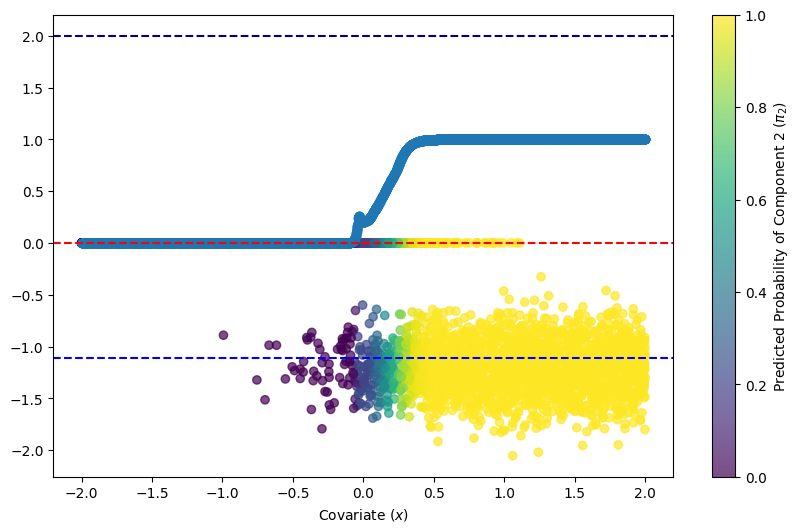

In [87]:
# Visualize predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=pi_2.numpy(), cmap='viridis', alpha=0.7, label='Data points')
plt.scatter(x, pi_2,  alpha=0.7 )
plt.colorbar(label='Predicted Probability of Component 2 ($\pi_2$)')
plt.axhline(0.0, color='red', linestyle='--', label='Fixed $\mu_1$')
plt.axhline(mu_2.mean().item(), color='blue', linestyle='--', label='Predicted $\mu_2$')

plt.axhline(2, color='darkblue', linestyle='--', label='Predicted $\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel


In [88]:
mu_2

Parameter containing:
tensor(-1.1127, requires_grad=True)

In [89]:
sigma_2_sq   **2


tensor(0.0003, grad_fn=<PowBackward0>)

In [90]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from empirical_mdn import *
from covaraite_moderated_generalized_binary import *

In [91]:
x

array([-1.38334863,  0.96019879, -0.94673994, ...,  0.18081505,
       -0.16155839,  0.45944063], shape=(5000,))

In [92]:
betahat= y
sebetahat = y*0+1






res= cgb_posterior_means(X=x,
                     betahat=betahat,
                     sebetahat=sebetahat)

Epoch 10/20, Loss: 1.2618
Epoch 20/20, Loss: 1.2582
